# Consumption & Income Dynamics

Managing the consumption and income dynamics has always been of particualr interests to Econimics in both micro and macro scale. In this example notebook, we are going to showcase the Reinforcement Learning (RL) capability in solving this problem. The RL agent tries to manage its wealth for maximum satistfaction based on a time dependent (random) income stream, expenses and taxation. 

![consumption_Income_dyanmics](.\pictures\C&I_D.jpg)

## Importing 

In [1]:
import gym
from os import path
from typing import Optional
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from model import Agent

## Environment

The environment has been designed as a Gym environment (subclass). Depending on whether the stochastic probabilistic transition kernel or the transition function are applied, it can be used as both a deterministic and a stochastic environment.

Deterministic: $$ y^\prime = f(y) = 0.8 y, $$

Stochastic: $$ y^\prime = T^\prime = \left\{
\begin{array}{ll}
      1.2 y & with p = 0.3 \\
      0.8 y & with p = 0.7 \\
\end{array} 
\right.  $$

Depending on the action the agent takes, which is the consumption amount $c$, it receives a reward according to the environment utility function. There are a variety of choices for utility function, in this example we use the Exponential Utility function. In economics and finance, exponential utility is a specific form of the utility function, used in some contexts because of its convenience when risk (sometimes referred to as uncertainty) is present. Formally, exponential utility is given by:
$$ 
u = \left\{
\begin{array}{ll}
      (1-e^{-\alpha c}) & a\neq0 \\
      c & \alpha = 0 \\
\end{array} 
\right.  
$$
We take $\alpha=1$ (risk aversion mode) for simplicity.
<img src=".\pictures\Exponential_Utility_Function.png" alt="drawing" width="300"/>


In [2]:
class ConsumptionIncomeDynamics(gym.Env):
    
    def __init__(self, max_a, max_w, max_y, seed):
        self.max_a = max_a
        self.max_w = max_w
        self.max_y = max_y
        self.seed = seed
        high = np.array([max_w, max_y], dtype=np.float32)

        self.action_space = spaces.Box(low=0, high=self.max_a, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=high, dtype=np.float32)

    def _prob_transition_kernel(self, prev_state):
        # np.random.seed(self.seed)
        p = np.random.rand()
        if p > 0.7:
            next_state = 1.2 * prev_state
        else:
            next_state = 0.8 * prev_state
        return next_state

    def _transition_kernel(self, prev_state):
        return 0.8 * prev_state
    
    def _get_obs(self):
        w, y = self.state
        return np.array([w, y], dtype=np.float32)

    def step(self, a):
        done = False
        w, y = self.state

        a = np.clip(a, 0, self.max_a)
        consumption = a * np.sum(self.state)
        reward = 1-np.exp(-consumption)

        new_w = w + y - consumption 
        new_w = np.clip(new_w, 0, self.max_w)
        new_y = self._transition_kernel(y)
        # new_y = self._prob_transition_kernel(y)

        self.state = np.array([new_w, new_y])

        return self._get_obs(), reward, done, False

    def reset(self, w_0, y_0, seed: Optional[int] = None):
        super().reset(seed=seed)
        np.random.seed(seed)
        w = w_0
        y = y_0
        self.state = np.array([w, y])
        return self._get_obs()

In [3]:
max_a = 1
max_w = 100
max_y = 100
seed = 0

gamma = 0.99

env = ConsumptionIncomeDynamics(max_a, max_w, max_y, seed)

## Baseline model

In [4]:
episode_length = 200
w_0 = 10
y_0 = 5

score_history = []

obs = env.reset(w_0=w_0, y_0=y_0, seed=seed)
done = False
score = 0
state_history = []
reward_history = []
cummulated_reward_history = []
action_hisotry = []
consumption_history = []
for t in range(episode_length):
    a = 0.9
    
    new_state, reward, done, info = env.step(a=a)
    
    reward_history.append(reward)
    state_history.append(new_state)
    action_hisotry.append(a)
    consumption_history.append(a * sum(env.state))

    score = score + (gamma * reward)
    cummulated_reward_history.append(score)
    obs = new_state

score_history.append(score)


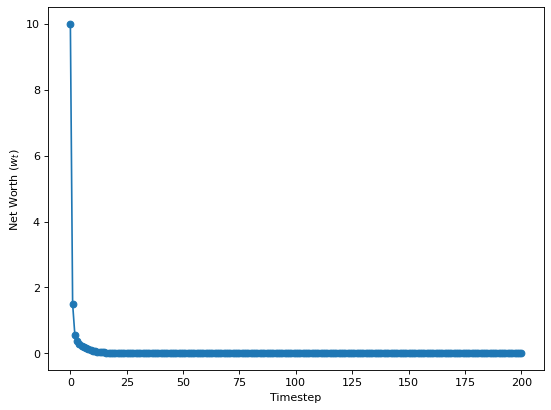

In [5]:
wealth_history = [w_0] + np.vstack(state_history)[:, 0].tolist()
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('Net Worth ($w_t$)')
plt.plot(wealth_history, marker='o')


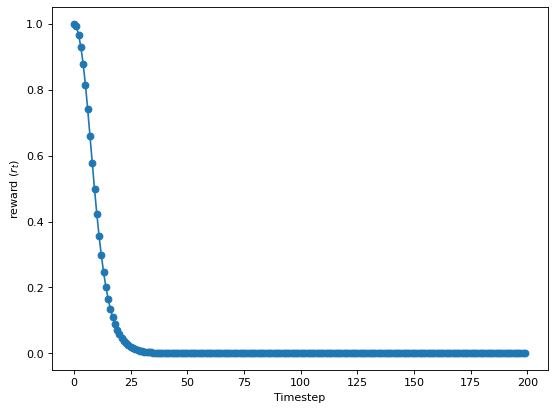

In [6]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('reward ($r_t$)')
plt.plot(reward_history, marker='o')

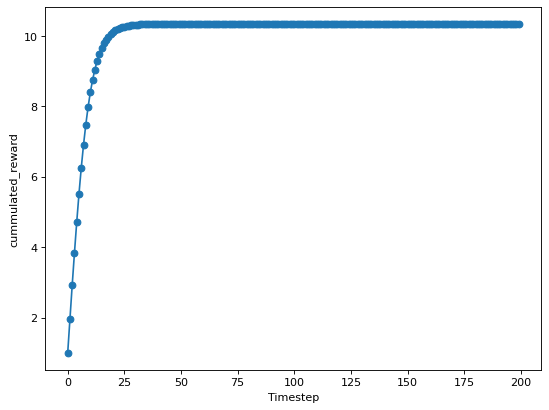

In [7]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('cummulated_reward')
plt.plot(cummulated_reward_history, marker='o')

In [8]:
score

10.341874980761968

In [9]:
baseline_score = score
baseline_reward_history = reward_history
baseline_cummulated_reward_history = cummulated_reward_history

## Learning 

In [10]:
gamma = 0.99
agent = Agent(alpha=0.05, beta=0.4, input_dims=[2] , tau=0.7, gamma=gamma, env=env, batch_size= 1, layer1_size=2, layer2_size=2, n_actions= 1)


In [11]:
num_episodes = 75
episode_length = 200
w_0 = 10
y_0 = 5
seed = 0

score_history = []
best_score = 0

for episode in range(num_episodes):
    obs = env.reset(w_0=w_0, y_0=y_0, seed=seed)
    done = False
    state_history = []
    reward_history = []
    cummulated_reward_history = []
    action_hisotry = []
    consumption_history = []
    score = 0
    for t in range(episode_length):
        state_history.append(env.state)

        a = agent.choose_action(obs).astype('double')
        action_hisotry.append(a)
        consumption_history.append(a * sum(env.state))

        new_state, reward, done, info = env.step(a=a)
        agent.remember(obs, a, reward, new_state, int(done))
        agent.learn()

        reward_history.append(reward)
        
        score = score + (gamma * reward)
        cummulated_reward_history.append(score)
        obs = new_state

    score_history.append(score)

    if score_history[episode] > best_score:
        best_score = score_history[episode]
        best_state_history = state_history
        best_action_hisotry = action_hisotry
        best_consumption_history = consumption_history
        best_reward_history = reward_history
        best_cummulated_reward_history = cummulated_reward_history
         
    print(f'episode: {episode}, total_discounted_return: {score}, training {num_episodes} games')


C:\Users\PIRMOE5\AppData\Local\Temp\ipykernel_13100\2784811896.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.state = np.array([new_w, new_y])
C:\Users\PIRMOE5\AppData\Local\Temp\ipykernel_13100\2784811896.py:27: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([w, y], dtype=np.float32)


episode: 0, total_discounted_return: [11.69783251], training 75 games
episode: 1, total_discounted_return: [11.7631339], training 75 games
episode: 2, total_discounted_return: [11.68308845], training 75 games
episode: 3, total_discounted_return: [11.0916307], training 75 games
episode: 4, total_discounted_return: [11.35557584], training 75 games
episode: 5, total_discounted_return: [11.95882508], training 75 games
episode: 6, total_discounted_return: [13.1866562], training 75 games
episode: 7, total_discounted_return: [13.86924804], training 75 games
episode: 8, total_discounted_return: [13.59336905], training 75 games
episode: 9, total_discounted_return: [12.26558531], training 75 games
episode: 10, total_discounted_return: [11.01422082], training 75 games
episode: 11, total_discounted_return: [11.00540175], training 75 games
episode: 12, total_discounted_return: [10.90687493], training 75 games
episode: 13, total_discounted_return: [11.35118282], training 75 games
episode: 14, total_

In [12]:
best_score

array([23.34871103])

In [13]:
def moving_average(a, n=15) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

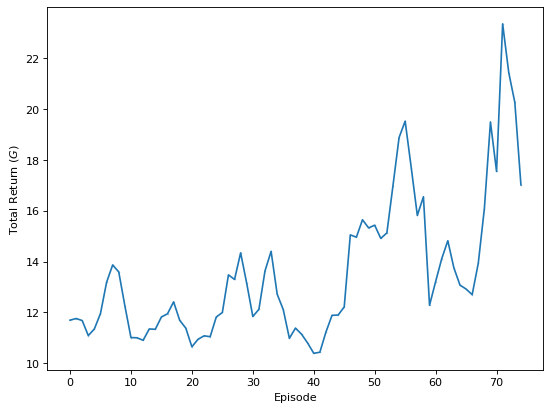

In [13]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Episode')
plt.ylabel('Total Return ($G$)')
plt.plot(score_history, marker='o', markersize=0.2)
# plt.plot(moving_average(score_history), marker='o', markersize=0.2, color='r')

C:\Users\PIRMOE5\myenv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


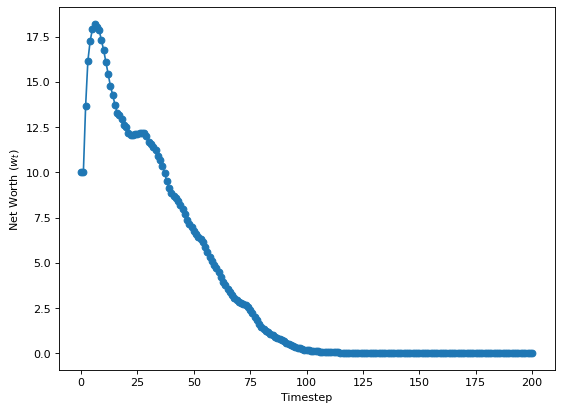

In [14]:
best_wealth_history = [w_0] + np.vstack(best_state_history)[:, 0].tolist()
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('Net Worth ($w_t$)')
plt.plot(best_wealth_history, marker='o')

In [15]:
for i in range(episode_length):
    print(f' time: {i} ==> state: {state_history[i]}, sum states: {sum(state_history[i])}, cunsumption: {consumption_history[i]}, reward: {reward_history[i]} \n')

 time: 0 ==> state: [10  5], sum states: 15, cunsumption: [2.60179281], reward: [0.92585946] 

 time: 1 ==> state: [array([12.39820719]) 4.0], sum states: [16.39820719], cunsumption: [2.78939668], reward: [0.93854172] 

 time: 2 ==> state: [array([13.60881051]) 3.2], sum states: [16.80881051], cunsumption: [3.25160084], reward: [0.96128781] 

 time: 3 ==> state: [array([13.55720967]) 2.5600000000000005], sum states: [16.11720967], cunsumption: [2.91275499], reward: [0.94567414] 

 time: 4 ==> state: [array([13.20445468]) 2.0480000000000005], sum states: [15.25245468], cunsumption: [2.62129201], reward: [0.92729114] 

 time: 5 ==> state: [array([12.63116268]) 1.6384000000000005], sum states: [14.26956268], cunsumption: [2.48332612], reward: [0.91653485] 

 time: 6 ==> state: [array([11.78623655]) 1.3107200000000006], sum states: [13.09695655], cunsumption: [2.12196536], reward: [0.88020405] 

 time: 7 ==> state: [array([10.97499119]) 1.0485760000000004], sum states: [12.02356719], cunsu

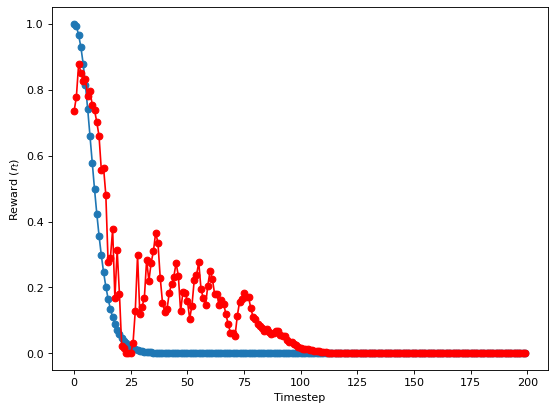

In [16]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('Reward ($r_t$)')
plt.plot(baseline_reward_history, marker='o')
plt.plot(best_reward_history, marker='o', color='r')

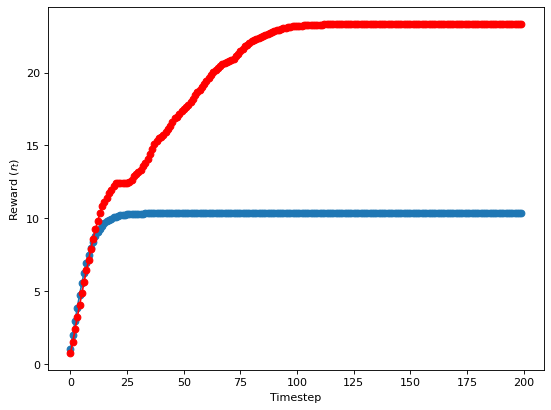

In [17]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('Reward ($r_t$)')
plt.plot(baseline_cummulated_reward_history, marker='o')
plt.plot(best_cummulated_reward_history, marker='o', color='r')

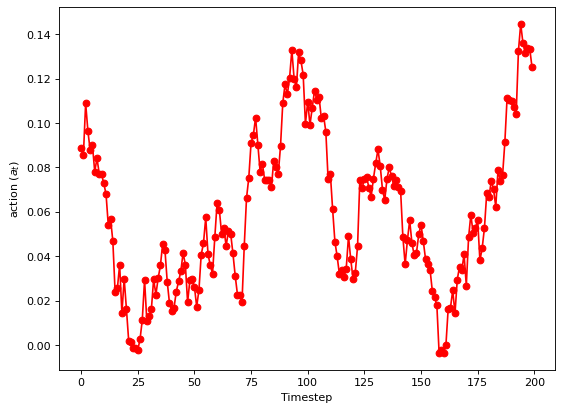

In [18]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Timestep')
plt.ylabel('action ($a_t$)')
plt.plot(best_action_hisotry, marker='o', color='r')